In [1]:
#import helper
import pandas as pd
#from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn

from sklearn.decomposition import PCA

from IPython.display import Image

import pennylane as qml


# Introduction

Stock price prediction is one of the most rewarding problems in modern finance, where the accurate forecasting of future stock prices can yield significant profit and reduce the risks. LSTM (Long Short-Term Memory) is a recurrent Neural Network (RNN) applicable to a broad range of problems aiming to analyze or classify sequential data. Therefore, many people have used LSTM to predict the future stock price based on the historical data sequences with great success.

On the other hand, recent studies have shown that the LSTM's efficiency and trainability can be improved by replacing some of the layers in the LSTM with variational quantum layers, thus making it a quantum-classical hybrid model of LSTM which we will call QLSTM for Quantum LSTM. In the study done by Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang, they show that QLSTM offers better trainability compared to its classical counterpart as it proved to learn significantly more information after the first training epoch than its classical counterpart, learnt the local features better, all while having a comparable number of parameters. Inspired by these recent results, we proceed to test this variational quantum-classical hybrid neural network technique on stock price predictions. 

In the following notebook, we show a proof of concept that QLSTM can be used to great effect for stock price prediction, offering comparable and arguably better results than its classical counterpart. To do so, we implement both LSTM and QLSTM to predict the stock prices of the company Merck & Co. Inc (MRK) with the same number of features, of which we chose based on earlier studies done with stock price predictions.

This submission was motivated by a combination of a few separate studies:

Stock price prediction use BERT and GAN: https://arxiv.org/pdf/2107.09055.pdf, Priyank Sonkiya, Vikas Bajpai, Anukriti Bansal <br>
Quantum Long Short-Term Memory: https://arxiv.org/pdf/2009.01783.pdf, Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang <br>

With code and ideas reused and repurposed from the following sources:

Example of a QLSTM: https://github.com/rdisipio/qlstm, Riccardo Di Sipio <br>
How to use PyTorch LSTMs for time series regression: https://www.crosstab.io/articles/time-series-pytorch-lstm, Brian Kent <br>
Using GANs to predict stock price movement: https://towardsdatascience.com/aifortrading-2edd6fac689d, Boris Banushev<br>

## Brief Outline

To demonstrate the use of QLSTM for stock prediction, we use the stock prices of the company Merck & Co. Inc (MRK). The notebook will proceed in the following manner:

1. Brief description of Data
2. Using Classical LSTM to perform stock price prediction
3. Defining QLSTM and using it to perform stock price prediction
4. Comparison between LSTM and QLSTM

Note that for the LSTM, we would be using PyTorch; while for the QLSTM we would be using PyTorch and Pennylane. 

# Experimentation

- weight decay coefficient (weight decay), 
- width of the layer (width), 
- mini-batch size (batch size), 
- learning rate (learning rate),
- dropout probability (dropout), 
- depth of the architecture(depth) 
- the choice of the optimization algorithms (optimizer)

number of iterations = batch_size * num_epochs

In [2]:
batch_size = 1
sequence_length = 3

weight_decay_value = 0
learning_rate = 0.0001

num_hidden_units = 64

In [3]:
#from torch.utils.tensorboard import SummaryWriter

In [4]:
#writer = SummaryWriter()

# Data

To briefly describe the data, we have collected the historical data of the MRK stock prices, of which we focus on the closing price. Our goal is then to forecast the closing stock prices of MRK using LSTM (or QLSTM). 

To achieve this goal, we have collected the data and information we thought necessary and important. This includes the following:

- Technical indicators
- Trend approximations (Fourier Transforms)
- ARIMA 
- Correlated assets
- Sentimental analysis

While interesting and important in its own right, we have decided not to go into detail for the data collection in this notebook. For more information, please go take a look at the Data Collection notebook also in this Github. 

In this section, our goal is to process the data to get it ready for the LSTM and QLSTM.

First, we read in the data, dropping the index and the date.

In [5]:
df = pd.read_csv('dataset_MRK_prediction.csv')
df = df.drop(['Date' ,'Unnamed: 0'], axis=1)
df

,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
0,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,27.528586,...,20.441219,22.546120,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327,31.011450,31.440840
1,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,27.372247,...,20.290920,22.639698,26.532934,6697.220215,2024.229980,55.359252,50.140845,47.659130,31.440840,31.183207
2,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,27.367319,...,20.280550,22.492653,26.608170,6687.939941,2024.430054,55.263482,49.944470,47.372320,31.183207,31.364504
3,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,27.383684,...,20.513784,22.800129,26.984316,6722.310059,2027.729980,55.167638,49.748691,47.086936,31.364504,30.839695
4,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,27.475534,...,20.285738,22.459227,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017,30.839695,30.944656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,1.705192,78.113220,71.292452,...,38.856968,148.141144,82.393753,12302.190430,9682.910156,57.910147,55.622779,55.790021,76.887436,77.814888
2713,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,71.231038,...,38.423382,146.373550,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641,78.191500,78.492363
2714,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,71.381377,...,38.469505,144.916718,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523,77.972240,79.103050
2715,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,71.507360,...,39.087601,144.916718,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711,78.309688,78.492363


We identify the dependent and independent variables:

In [6]:
target = "Close_lead1"

In [7]:
features = list(df.columns.difference(["Close", 'Close_lead1']))
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

## Data Processing

To process the data, we first split it into training and test data, where two-thirds of the data is used for training, and the last third is used for testing.

In [8]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

Next, in order to ensure that some values don't inherently dominate the features due to their magnitude, we standardize their values.

In [9]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [10]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

Finally, the last step in the data processing to prepare it for LSTM is to prepare the data in a sequence of past observations. Preparing LSTM on time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance. If the sequence length is $n$, then the LSTM considers the last $n$ observations to predict the $n+1$th day.

The sequence length we decided on is 3 for purposes of this notebook.

In [11]:
torch.manual_seed(101)

#batch_size = 10
#sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 32])
Target shape: torch.Size([1])


In [12]:
i = 0
for _ in train_loader:
    i += 1 
print(i)

1821


# Classical LSTM

We first define two functions:
    
- train_model: function to train the model based on the batches of data
- test_model: function to test the model on the testing data
    
For both, they print the loss at the end to let us know how the model is performing with regards to the data.

In [13]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def trading_model(data_loader, model, loss_function, initial_inv, initial_price):
    
    # initial seed money
    inv = initial_inv
    
    # initial price of stock
    price = initial_price
    
    # initial number of stock 
    number_stocks = 0
    
    # predicted earnings
    pred_earn = 0 
    
    # predicted stock
    pred_output = []
    
    # day
    day = 1
    
    for X, y in data_loader:
        model.eval()
        with torch.no_grad():
            output = model(X)
            
            pred_price =  output * target_stdev + target_mean
            pred_output.append(pred_price)
            print("Today's stock price: ", price)
            print("Predicted stock price for tomorrow: ", pred_price)
            
            #if predicted value next day higher than today's price
            if pred_price > price:
                number_stocks = number_stocks + inv/price
                inv = 0
                print("Day", day, ": Bought/Keep ", number_stocks, "stocks at price ", price)
                pred_earn = pred_earn + number_stocks * (pred_price - price)
                print("Predicted earnings: ", pred_earn)
                
                
            #if predicted value next day lower than (or equal to)  today's price
            else:
                inv = inv + number_stocks * price
                print("Day", day, ": Sold ", number_stocks, "at price ", price)
                number_stocks = 0
            
            # Update price
            price = y * target_stdev + target_mean
            day += 1
            print("Current number of stocks: ", number_stocks)
            print("Current seed money:", inv)
        
        model.train()
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    total_earnings = number_stocks*price + inv
    print(f"Trading earnings: {total_earnings}")
    print(f"Predicted earnings: {pred_earn}")
    return pred_output
    


## Running the Classical LSTM

To understand how we implemented QLSTM, we have to first understand how we implemented LSTM. LSTM follows the following structure:

<img src="lstm2.jpg" alt="drawing" width="400"/>

Image taken from: Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf. By Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang

Simply put, LSTM uses 4 neural network layers in each LSTM cell to perform its functions. They are:

- Forget layer
- Input layer
- Update layer
- Output layer

You can see the corresponding layers in the W cells in the picture above. We will be skipping the technical details, as you can find better information on the theory elsewhere, but it is important to note that these 4 layers are the key to building an LSTM neural network model that we can train and eventually use to predict, and usually take the form of a normal NN layer (like a linear layer with reLU or convolutional layers).

LSTMs are well studied, and there is a native implementation of it in PyTorch to begin with, so we use a slightly modified version of it for the time series LSTM that we perform here. The code for the time series LSTM was reused from:

How to use PyTorch LSTMs for time series regression: https://www.crosstab.io/articles/time-series-pytorch-lstm, Brian Kent.

In the following code, we train LSTM to predict future stock prices, and then test it on the test dataset. The learning rate of 0.0001 was decided after some experimentation, where we chose the learning rate that most reliably gave accurate results. The number of epochs we use is 20, by which it would have converged and thus would suffice for the purposes of this notebook. After that, we proceed to see 3 different graphs: the comparison between the real stock prices and the ones given by the model; and the evolution of test loss and training loss by epoch.

# Experimentation

In [14]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [15]:
#learning_rate = 0.0001
#num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay_value)

In [16]:
classical_loss_train = []
classical_loss_test = []
classical_time = []
print("Untrained test\n--------")
start = time.time()
test_loss = test_model(test_loader, model, loss_function)
end = time.time()
print("Execution time", end - start)
classical_loss_test.append(test_loss)
classical_time.append(end - start)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    start = time.time()
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    end = time.time()
    print("Execution time", end - start)
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)
    classical_time.append(end - start)

Untrained test
--------
Test loss: 7.820826945429794
Execution time 0.47274065017700195
Epoch 0
---------


C:\Users\jonas\Anaconda3\envs\qrnn\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Train loss: 0.06958353877781068
Test loss: 1.0426682614230711
Execution time 8.689605474472046
Epoch 1
---------
Train loss: 0.008384597654472642
Test loss: 0.7326885918496581
Execution time 7.252810716629028
Epoch 2
---------
Train loss: 0.006803452925586157
Test loss: 0.6432107367587666
Execution time 7.154213905334473
Epoch 3
---------
Train loss: 0.006306810445816526
Test loss: 0.481162647513634
Execution time 7.861607074737549
Epoch 4
---------
Train loss: 0.005872185736101749
Test loss: 0.5243689328602329
Execution time 7.735856056213379
Epoch 5
---------
Train loss: 0.005536693069409147
Test loss: 0.5225586694471384
Execution time 7.228842258453369
Epoch 6
---------
Train loss: 0.00509277869334778
Test loss: 0.4133938403835197
Execution time 7.224776029586792
Epoch 7
---------
Train loss: 0.004925402115869232
Test loss: 0.37126636181876554
Execution time 7.215131759643555
Epoch 8
---------
Train loss: 0.004764344716678808
Test loss: 0.4330668421701149
Execution time 7.0919578075

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [17]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [18]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

      Close_lead1  Model forecast
0       31.440840       31.119629
1       31.183207       31.482601
2       31.364504       31.401638
3       30.839695       31.503222
4       30.944656       31.228518
...           ...             ...
2712    77.814888       69.086830
2713    78.492363       69.140739
2714    79.103050       69.196259
2715    78.492363       69.403358
2716    78.024811       69.381783

[2718 rows x 2 columns]


In [19]:
df_out = df_out[~df_out.index.duplicated(keep='first')]

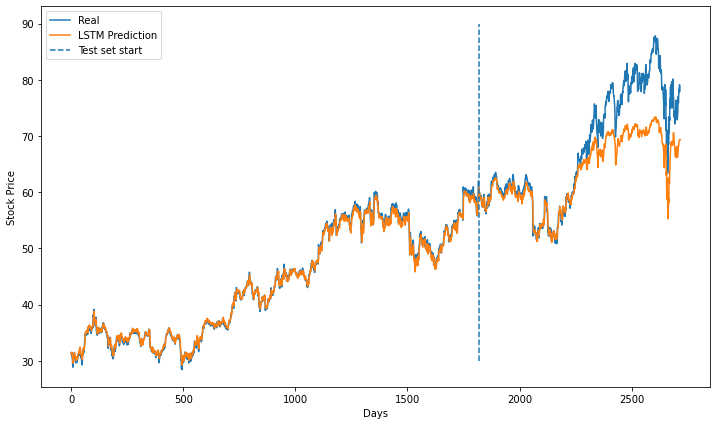

In [20]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_out)), df_out["Close_lead1"], label = "Real")
plt.plot(range(len(df_out)), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

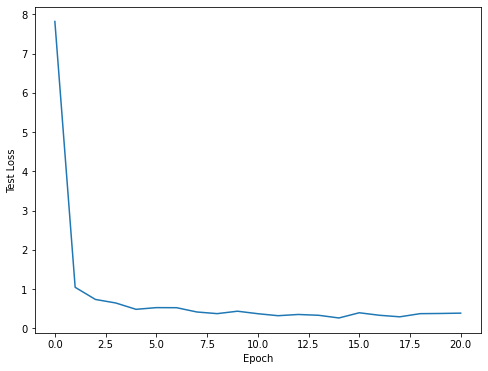

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), classical_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

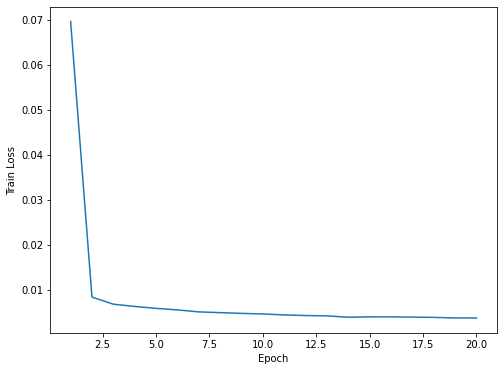

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()

# Trading

In [23]:
df_out["Close_lead1"][size - 1]

60.620228

In [24]:
initial_inv = 10000
initial_price = df_out["Close_lead1"][size - 1]

In [25]:
pred_output = trading_model(test_loader, model, loss_function, initial_inv, initial_price)

Today's stock price:  60.620228
Predicted stock price for tomorrow:  tensor([59.5345])
Day 1 : Sold  0 at price  60.620228
Current number of stocks:  0
Current seed money: 10000.0
Today's stock price:  tensor([60.7347])
Predicted stock price for tomorrow:  tensor([59.9338])
Day 2 : Sold  0 at price  tensor([60.7347])
Current number of stocks:  0
Current seed money: tensor([10000.])
Today's stock price:  tensor([59.7615])
Predicted stock price for tomorrow:  tensor([59.6995])
Day 3 : Sold  0 at price  tensor([59.7615])
Current number of stocks:  0
Current seed money: tensor([10000.])
Today's stock price:  tensor([59.8282])
Predicted stock price for tomorrow:  tensor([59.6684])
Day 4 : Sold  0 at price  tensor([59.8282])
Current number of stocks:  0
Current seed money: tensor([10000.])
Today's stock price:  tensor([59.0363])
Predicted stock price for tomorrow:  tensor([59.1758])
Day 5 : Bought  tensor([169.3874]) stocks at price  tensor([59.0363])
Predicted earnings:  tensor([23.6379])
C

Today's stock price:  tensor([58.4065])
Predicted stock price for tomorrow:  tensor([58.8003])
Day 48 : Bought  tensor([173.9291]) stocks at price  tensor([58.4065])
Predicted earnings:  tensor([986.9517])
Current number of stocks:  tensor([173.9291])
Current seed money: 0
Today's stock price:  tensor([58.2824])
Predicted stock price for tomorrow:  tensor([58.7845])
Day 49 : Bought  tensor([173.9291]) stocks at price  tensor([58.2824])
Predicted earnings:  tensor([1074.2805])
Current number of stocks:  tensor([173.9291])
Current seed money: 0
Today's stock price:  tensor([58.3969])
Predicted stock price for tomorrow:  tensor([58.9483])
Day 50 : Bought  tensor([173.9291]) stocks at price  tensor([58.3969])
Predicted earnings:  tensor([1170.1763])
Current number of stocks:  tensor([173.9291])
Current seed money: 0
Today's stock price:  tensor([58.9218])
Predicted stock price for tomorrow:  tensor([58.8318])
Day 51 : Sold  tensor([173.9291]) at price  tensor([58.9218])
Current number of s

Today's stock price:  tensor([60.6298])
Predicted stock price for tomorrow:  tensor([60.3212])
Day 95 : Sold  0 at price  tensor([60.6298])
Current number of stocks:  0
Current seed money: tensor([10770.7715])
Today's stock price:  tensor([60.5630])
Predicted stock price for tomorrow:  tensor([60.6891])
Day 96 : Bought  tensor([177.8442]) stocks at price  tensor([60.5630])
Predicted earnings:  tensor([2217.3420])
Current number of stocks:  tensor([177.8442])
Current seed money: 0
Today's stock price:  tensor([60.7538])
Predicted stock price for tomorrow:  tensor([60.3965])
Day 97 : Sold  tensor([177.8442]) at price  tensor([60.7538])
Current number of stocks:  0
Current seed money: tensor([10804.7119])
Today's stock price:  tensor([60.6584])
Predicted stock price for tomorrow:  tensor([60.2372])
Day 98 : Sold  0 at price  tensor([60.6584])
Current number of stocks:  0
Current seed money: tensor([10804.7119])
Today's stock price:  tensor([60.3435])
Predicted stock price for tomorrow:  t

Today's stock price:  tensor([62.0897])
Predicted stock price for tomorrow:  tensor([62.4095])
Day 139 : Bought  tensor([190.4356]) stocks at price  tensor([62.0897])
Predicted earnings:  tensor([3082.8389])
Current number of stocks:  tensor([190.4356])
Current seed money: 0
Today's stock price:  tensor([61.7080])
Predicted stock price for tomorrow:  tensor([62.1071])
Day 140 : Bought  tensor([190.4356]) stocks at price  tensor([61.7080])
Predicted earnings:  tensor([3158.8303])
Current number of stocks:  tensor([190.4356])
Current seed money: 0
Today's stock price:  tensor([61.1260])
Predicted stock price for tomorrow:  tensor([61.6922])
Day 141 : Bought  tensor([190.4356]) stocks at price  tensor([61.1260])
Predicted earnings:  tensor([3266.6550])
Current number of stocks:  tensor([190.4356])
Current seed money: 0
Today's stock price:  tensor([60.3053])
Predicted stock price for tomorrow:  tensor([61.0116])
Day 142 : Bought  tensor([190.4356]) stocks at price  tensor([60.3053])
Predi

Today's stock price:  tensor([60.2099])
Predicted stock price for tomorrow:  tensor([60.4000])
Day 182 : Bought  tensor([184.2457]) stocks at price  tensor([60.2099])
Predicted earnings:  tensor([4249.2417])
Current number of stocks:  tensor([184.2457])
Current seed money: 0
Today's stock price:  tensor([59.9618])
Predicted stock price for tomorrow:  tensor([60.2265])
Day 183 : Bought  tensor([184.2457]) stocks at price  tensor([59.9618])
Predicted earnings:  tensor([4298.0020])
Current number of stocks:  tensor([184.2457])
Current seed money: 0
Today's stock price:  tensor([59.4656])
Predicted stock price for tomorrow:  tensor([59.9095])
Day 184 : Bought  tensor([184.2457]) stocks at price  tensor([59.4656])
Predicted earnings:  tensor([4379.7837])
Current number of stocks:  tensor([184.2457])
Current seed money: 0
Today's stock price:  tensor([59.6279])
Predicted stock price for tomorrow:  tensor([59.7793])
Day 185 : Bought  tensor([184.2457]) stocks at price  tensor([59.6279])
Predi

Current seed money: tensor([11109.9766])
Today's stock price:  tensor([60.8588])
Predicted stock price for tomorrow:  tensor([60.9567])
Day 229 : Bought  tensor([182.5534]) stocks at price  tensor([60.8588])
Predicted earnings:  tensor([5536.3682])
Current number of stocks:  tensor([182.5534])
Current seed money: 0
Today's stock price:  tensor([60.9065])
Predicted stock price for tomorrow:  tensor([60.6682])
Day 230 : Sold  tensor([182.5534]) at price  tensor([60.9065])
Current number of stocks:  0
Current seed money: tensor([11118.6865])
Today's stock price:  tensor([60.4866])
Predicted stock price for tomorrow:  tensor([60.5081])
Day 231 : Bought  tensor([183.8205]) stocks at price  tensor([60.4866])
Predicted earnings:  tensor([5540.3159])
Current number of stocks:  tensor([183.8205])
Current seed money: 0
Today's stock price:  tensor([60.4389])
Predicted stock price for tomorrow:  tensor([60.2957])
Day 232 : Sold  tensor([183.8205]) at price  tensor([60.4389])
Current number of sto

Today's stock price:  tensor([53.7786])
Predicted stock price for tomorrow:  tensor([54.2571])
Day 280 : Bought  tensor([187.7649]) stocks at price  tensor([53.7786])
Predicted earnings:  tensor([7536.4956])
Current number of stocks:  tensor([187.7649])
Current seed money: 0
Today's stock price:  tensor([53.7595])
Predicted stock price for tomorrow:  tensor([54.5417])
Day 281 : Bought  tensor([187.7649]) stocks at price  tensor([53.7595])
Predicted earnings:  tensor([7683.3511])
Current number of stocks:  tensor([187.7649])
Current seed money: 0
Today's stock price:  tensor([53.7595])
Predicted stock price for tomorrow:  tensor([54.4422])
Day 282 : Bought  tensor([187.7649]) stocks at price  tensor([53.7595])
Predicted earnings:  tensor([7811.5312])
Current number of stocks:  tensor([187.7649])
Current seed money: 0
Today's stock price:  tensor([54.0076])
Predicted stock price for tomorrow:  tensor([54.1042])
Day 283 : Bought  tensor([187.7649]) stocks at price  tensor([54.0076])
Predi

Today's stock price:  tensor([51.9752])
Predicted stock price for tomorrow:  tensor([51.8806])
Day 329 : Sold  0 at price  tensor([51.9752])
Current number of stocks:  0
Current seed money: tensor([9020.2842])
Today's stock price:  tensor([52.2519])
Predicted stock price for tomorrow:  tensor([51.9326])
Day 330 : Sold  0 at price  tensor([52.2519])
Current number of stocks:  0
Current seed money: tensor([9020.2842])
Today's stock price:  tensor([52.6145])
Predicted stock price for tomorrow:  tensor([52.3516])
Day 331 : Sold  0 at price  tensor([52.6145])
Current number of stocks:  0
Current seed money: tensor([9020.2842])
Today's stock price:  tensor([52.8244])
Predicted stock price for tomorrow:  tensor([52.5549])
Day 332 : Sold  0 at price  tensor([52.8244])
Current number of stocks:  0
Current seed money: tensor([9020.2842])
Today's stock price:  tensor([52.8340])
Predicted stock price for tomorrow:  tensor([52.4238])
Day 333 : Sold  0 at price  tensor([52.8340])
Current number of s

Today's stock price:  tensor([55.4008])
Predicted stock price for tomorrow:  tensor([56.7806])
Day 374 : Bought  tensor([168.5281]) stocks at price  tensor([55.4008])
Predicted earnings:  tensor([13097.6934])
Current number of stocks:  tensor([168.5281])
Current seed money: 0
Today's stock price:  tensor([56.9561])
Predicted stock price for tomorrow:  tensor([57.4941])
Day 375 : Bought  tensor([168.5281]) stocks at price  tensor([56.9561])
Predicted earnings:  tensor([13188.3574])
Current number of stocks:  tensor([168.5281])
Current seed money: 0
Today's stock price:  tensor([56.9466])
Predicted stock price for tomorrow:  tensor([57.9334])
Day 376 : Bought  tensor([168.5281]) stocks at price  tensor([56.9466])
Predicted earnings:  tensor([13354.6621])
Current number of stocks:  tensor([168.5281])
Current seed money: 0
Today's stock price:  tensor([56.4885])
Predicted stock price for tomorrow:  tensor([57.5505])
Day 377 : Bought  tensor([168.5281]) stocks at price  tensor([56.4885])
Pr

Current number of stocks:  0
Current seed money: tensor([9986.9658])
Today's stock price:  tensor([59.7233])
Predicted stock price for tomorrow:  tensor([59.7229])
Day 419 : Sold  0 at price  tensor([59.7233])
Current number of stocks:  0
Current seed money: tensor([9986.9658])
Today's stock price:  tensor([59.6660])
Predicted stock price for tomorrow:  tensor([59.6266])
Day 420 : Sold  0 at price  tensor([59.6660])
Current number of stocks:  0
Current seed money: tensor([9986.9658])
Today's stock price:  tensor([60.0573])
Predicted stock price for tomorrow:  tensor([59.7962])
Day 421 : Sold  0 at price  tensor([60.0573])
Current number of stocks:  0
Current seed money: tensor([9986.9658])
Today's stock price:  tensor([59.6469])
Predicted stock price for tomorrow:  tensor([59.6877])
Day 422 : Bought  tensor([167.4347]) stocks at price  tensor([59.6469])
Predicted earnings:  tensor([15289.6338])
Current number of stocks:  tensor([167.4347])
Current seed money: 0
Today's stock price:  te

Today's stock price:  tensor([65.4485])
Predicted stock price for tomorrow:  tensor([65.8171])
Day 453 : Bought  tensor([160.1510]) stocks at price  tensor([65.4485])
Predicted earnings:  tensor([16195.2920])
Current number of stocks:  tensor([160.1510])
Current seed money: 0
Today's stock price:  tensor([64.8378])
Predicted stock price for tomorrow:  tensor([65.4528])
Day 454 : Bought  tensor([160.1510]) stocks at price  tensor([64.8378])
Predicted earnings:  tensor([16293.7812])
Current number of stocks:  tensor([160.1510])
Current seed money: 0
Today's stock price:  tensor([65.4771])
Predicted stock price for tomorrow:  tensor([65.6016])
Day 455 : Bought  tensor([160.1510]) stocks at price  tensor([65.4771])
Predicted earnings:  tensor([16313.7129])
Current number of stocks:  tensor([160.1510])
Current seed money: 0
Today's stock price:  tensor([66.2023])
Predicted stock price for tomorrow:  tensor([65.7973])
Day 456 : Sold  tensor([160.1510]) at price  tensor([66.2023])
Current num

Today's stock price:  tensor([71.6412])
Predicted stock price for tomorrow:  tensor([70.6201])
Day 500 : Sold  0 at price  tensor([71.6412])
Current number of stocks:  0
Current seed money: tensor([11025.5820])
Today's stock price:  tensor([72.0229])
Predicted stock price for tomorrow:  tensor([71.3821])
Day 501 : Sold  0 at price  tensor([72.0229])
Current number of stocks:  0
Current seed money: tensor([11025.5820])
Today's stock price:  tensor([71.4313])
Predicted stock price for tomorrow:  tensor([71.6810])
Day 502 : Bought  tensor([154.3523]) stocks at price  tensor([71.4313])
Predicted earnings:  tensor([17399.3672])
Current number of stocks:  tensor([154.3523])
Current seed money: 0
Today's stock price:  tensor([71.2691])
Predicted stock price for tomorrow:  tensor([71.8053])
Day 503 : Bought  tensor([154.3523]) stocks at price  tensor([71.2691])
Predicted earnings:  tensor([17482.1309])
Current number of stocks:  tensor([154.3523])
Current seed money: 0
Today's stock price:  te

Today's stock price:  tensor([72.9103])
Predicted stock price for tomorrow:  tensor([71.3130])
Day 535 : Sold  0 at price  tensor([72.9103])
Current number of stocks:  0
Current seed money: tensor([11675.7480])
Today's stock price:  tensor([72.1279])
Predicted stock price for tomorrow:  tensor([71.2790])
Day 536 : Sold  0 at price  tensor([72.1279])
Current number of stocks:  0
Current seed money: tensor([11675.7480])
Today's stock price:  tensor([70.6489])
Predicted stock price for tomorrow:  tensor([70.4204])
Day 537 : Sold  0 at price  tensor([70.6489])
Current number of stocks:  0
Current seed money: tensor([11675.7480])
Today's stock price:  tensor([72.7767])
Predicted stock price for tomorrow:  tensor([71.8080])
Day 538 : Sold  0 at price  tensor([72.7767])
Current number of stocks:  0
Current seed money: tensor([11675.7480])
Today's stock price:  tensor([71.9752])
Predicted stock price for tomorrow:  tensor([71.8043])
Day 539 : Sold  0 at price  tensor([71.9752])
Current number 

Predicted earnings:  tensor([21498.0039])
Current number of stocks:  tensor([161.5391])
Current seed money: 0
Today's stock price:  tensor([77.1660])
Predicted stock price for tomorrow:  tensor([77.6975])
Day 582 : Bought  tensor([161.5391]) stocks at price  tensor([77.1660])
Predicted earnings:  tensor([21583.8516])
Current number of stocks:  tensor([161.5391])
Current seed money: 0
Today's stock price:  tensor([77.5095])
Predicted stock price for tomorrow:  tensor([77.7163])
Day 583 : Bought  tensor([161.5391]) stocks at price  tensor([77.5095])
Predicted earnings:  tensor([21617.2441])
Current number of stocks:  tensor([161.5391])
Current seed money: 0
Today's stock price:  tensor([77.8626])
Predicted stock price for tomorrow:  tensor([77.7616])
Day 584 : Sold  tensor([161.5391]) at price  tensor([77.8626])
Current number of stocks:  0
Current seed money: tensor([12577.8555])
Today's stock price:  tensor([77.7576])
Predicted stock price for tomorrow:  tensor([77.8372])
Day 585 : Bou

Day 631 : Sold  tensor([154.3551]) at price  tensor([75.2672])
Current number of stocks:  0
Current seed money: tensor([11617.8750])
Today's stock price:  tensor([75.8588])
Predicted stock price for tomorrow:  tensor([75.6297])
Day 632 : Sold  0 at price  tensor([75.8588])
Current number of stocks:  0
Current seed money: tensor([11617.8750])
Today's stock price:  tensor([77.2710])
Predicted stock price for tomorrow:  tensor([76.2472])
Day 633 : Sold  0 at price  tensor([77.2710])
Current number of stocks:  0
Current seed money: tensor([11617.8750])
Today's stock price:  tensor([77.3092])
Predicted stock price for tomorrow:  tensor([76.3366])
Day 634 : Sold  0 at price  tensor([77.3092])
Current number of stocks:  0
Current seed money: tensor([11617.8750])
Today's stock price:  tensor([77.4523])
Predicted stock price for tomorrow:  tensor([76.6328])
Day 635 : Sold  0 at price  tensor([77.4523])
Current number of stocks:  0
Current seed money: tensor([11617.8750])
Today's stock price:  t

Current number of stocks:  tensor([148.0914])
Current seed money: 0
Today's stock price:  tensor([78.7118])
Predicted stock price for tomorrow:  tensor([78.0136])
Day 679 : Sold  tensor([148.0914]) at price  tensor([78.7118])
Current number of stocks:  0
Current seed money: tensor([11656.5449])
Today's stock price:  tensor([79.4561])
Predicted stock price for tomorrow:  tensor([77.9047])
Day 680 : Sold  0 at price  tensor([79.4561])
Current number of stocks:  0
Current seed money: tensor([11656.5449])
Today's stock price:  tensor([79.1889])
Predicted stock price for tomorrow:  tensor([78.1196])
Day 681 : Sold  0 at price  tensor([79.1889])
Current number of stocks:  0
Current seed money: tensor([11656.5449])
Today's stock price:  tensor([79.8569])
Predicted stock price for tomorrow:  tensor([77.7986])
Day 682 : Sold  0 at price  tensor([79.8569])
Current number of stocks:  0
Current seed money: tensor([11656.5449])
Today's stock price:  tensor([80.6011])
Predicted stock price for tomor

Today's stock price:  tensor([81.1069])
Predicted stock price for tomorrow:  tensor([78.6975])
Day 727 : Sold  0 at price  tensor([81.1069])
Current number of stocks:  0
Current seed money: tensor([11920.7266])
Today's stock price:  tensor([80.5248])
Predicted stock price for tomorrow:  tensor([78.8135])
Day 728 : Sold  0 at price  tensor([80.5248])
Current number of stocks:  0
Current seed money: tensor([11920.7266])
Today's stock price:  tensor([79.4752])
Predicted stock price for tomorrow:  tensor([77.4195])
Day 729 : Sold  0 at price  tensor([79.4752])
Current number of stocks:  0
Current seed money: tensor([11920.7266])
Today's stock price:  tensor([80.3244])
Predicted stock price for tomorrow:  tensor([78.6661])
Day 730 : Sold  0 at price  tensor([80.3244])
Current number of stocks:  0
Current seed money: tensor([11920.7266])
Today's stock price:  tensor([79.9237])
Predicted stock price for tomorrow:  tensor([78.9190])
Day 731 : Sold  0 at price  tensor([79.9237])
Current number 

Today's stock price:  tensor([85.2004])
Predicted stock price for tomorrow:  tensor([84.7788])
Day 777 : Sold  0 at price  tensor([85.2004])
Current number of stocks:  0
Current seed money: tensor([12186.2949])
Today's stock price:  tensor([84.9427])
Predicted stock price for tomorrow:  tensor([85.2090])
Day 778 : Bought  tensor([143.4648]) stocks at price  tensor([84.9427])
Predicted earnings:  tensor([33276.5117])
Current number of stocks:  tensor([143.4648])
Current seed money: 0
Today's stock price:  tensor([85.5153])
Predicted stock price for tomorrow:  tensor([85.5284])
Day 779 : Bought  tensor([143.4648]) stocks at price  tensor([85.5153])
Predicted earnings:  tensor([33278.4023])
Current number of stocks:  tensor([143.4648])
Current seed money: 0
Today's stock price:  tensor([85.8683])
Predicted stock price for tomorrow:  tensor([85.6506])
Day 780 : Sold  tensor([143.4648]) at price  tensor([85.8683])
Current number of stocks:  0
Current seed money: tensor([12319.0820])
Today's

Today's stock price:  tensor([76.2786])
Predicted stock price for tomorrow:  tensor([76.2731])
Day 825 : Sold  tensor([152.2917]) at price  tensor([76.2786])
Current number of stocks:  0
Current seed money: tensor([11616.5996])
Today's stock price:  tensor([74.5038])
Predicted stock price for tomorrow:  tensor([75.0963])
Day 826 : Bought  tensor([155.9195]) stocks at price  tensor([74.5038])
Predicted earnings:  tensor([39233.7891])
Current number of stocks:  tensor([155.9195])
Current seed money: 0
Today's stock price:  tensor([73.0534])
Predicted stock price for tomorrow:  tensor([72.3862])
Day 827 : Sold  tensor([155.9195]) at price  tensor([73.0534])
Current number of stocks:  0
Current seed money: tensor([11390.4570])
Today's stock price:  tensor([77.6431])
Predicted stock price for tomorrow:  tensor([75.8463])
Day 828 : Sold  0 at price  tensor([77.6431])
Current number of stocks:  0
Current seed money: tensor([11390.4570])
Today's stock price:  tensor([75.5057])
Predicted stock 

Day 875 : Bought  tensor([194.2807]) stocks at price  tensor([72.1374])
Predicted earnings:  tensor([45427.1523])
Current number of stocks:  tensor([194.2807])
Current seed money: 0
Today's stock price:  tensor([72.9008])
Predicted stock price for tomorrow:  tensor([73.9402])
Day 876 : Bought  tensor([194.2807]) stocks at price  tensor([72.9008])
Predicted earnings:  tensor([45629.1055])
Current number of stocks:  tensor([194.2807])
Current seed money: 0
Today's stock price:  tensor([74.3416])
Predicted stock price for tomorrow:  tensor([74.5651])
Day 877 : Bought  tensor([194.2807]) stocks at price  tensor([74.3416])
Predicted earnings:  tensor([45672.5195])
Current number of stocks:  tensor([194.2807])
Current seed money: 0
Today's stock price:  tensor([73.6546])
Predicted stock price for tomorrow:  tensor([73.7607])
Day 878 : Bought  tensor([194.2807]) stocks at price  tensor([73.6546])
Predicted earnings:  tensor([45693.1367])
Current number of stocks:  tensor([194.2807])
Current s

In [26]:
pred_output

[tensor([59.5345]),
 tensor([59.9338]),
 tensor([59.6995]),
 tensor([59.6684]),
 tensor([59.1758]),
 tensor([59.1669]),
 tensor([58.9385]),
 tensor([58.6927]),
 tensor([58.9203]),
 tensor([58.6980]),
 tensor([59.0464]),
 tensor([58.5281]),
 tensor([57.8646]),
 tensor([58.0617]),
 tensor([57.6437]),
 tensor([57.5526]),
 tensor([57.4652]),
 tensor([57.1796]),
 tensor([57.7978]),
 tensor([58.3659]),
 tensor([58.6382]),
 tensor([58.5091]),
 tensor([59.0175]),
 tensor([59.3587]),
 tensor([58.8641]),
 tensor([58.1879]),
 tensor([57.2840]),
 tensor([57.1251]),
 tensor([57.3592]),
 tensor([57.2358]),
 tensor([56.7214]),
 tensor([56.6316]),
 tensor([56.5203]),
 tensor([57.1245]),
 tensor([57.1963]),
 tensor([57.2562]),
 tensor([57.2784]),
 tensor([57.8222]),
 tensor([57.5219]),
 tensor([58.0476]),
 tensor([58.7362]),
 tensor([59.1122]),
 tensor([58.8542]),
 tensor([58.5354]),
 tensor([58.0013]),
 tensor([59.2704]),
 tensor([59.1606]),
 tensor([58.8003]),
 tensor([58.7845]),
 tensor([58.9483]),


C:\Users\jonas\Anaconda3\envs\qrnn\lib\site-packages\numpy\core\shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
C:\Users\jonas\Anaconda3\envs\qrnn\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


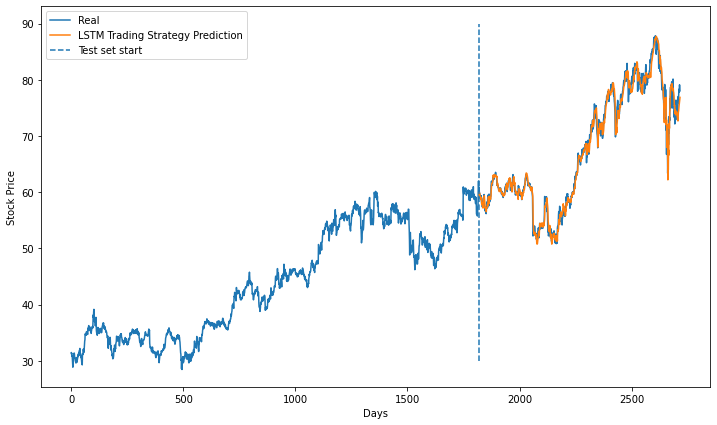

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_out)), df_out["Close_lead1"], label = "Real")
plt.plot(range(size, len(df_out)), pred_output, label = "LSTM Trading Strategy Prediction")
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

In [28]:
def max_trade(data_loader, initial_inv, initial_price):
    
    # initial seed money
    inv = initial_inv
    
    # initial price of stock
    price = initial_price
    
    # initial number of stock 
    number_stocks = 0
    
    # predicted earnings
    pred_earn = 0 
    
    # predicted stock
    pred_output = []
    
    # day
    day = 1
    
    for X, y in data_loader:
        model.eval()

        pred_price =  y * target_stdev + target_mean
        pred_output.append(pred_price)
        print("Today's stock price: ", price)
        print("Predicted stock price for tomorrow: ", pred_price)

        #if predicted value next day higher than today's price
        if pred_price > price:
            number_stocks = number_stocks + inv/price
            inv = 0
            print("Day", day, ": Bought/Keep ", number_stocks, "stocks at price ", price)
            pred_earn = pred_earn + number_stocks * (pred_price - price)
            print("Predicted earnings: ", pred_earn)


        #if predicted value next day lower than (or equal to)  today's price
        else:
            inv = inv + number_stocks * price
            print("Day", day, ": Sold ", number_stocks, "at price ", price)
            number_stocks = 0

        # Update price
        price = y * target_stdev + target_mean
        day += 1
        print("Current number of stocks: ", number_stocks)
        print("Current seed money:", inv)
        
        
    total_earnings = number_stocks*price + inv
    print(f"Trading earnings: {total_earnings}")
    print(f"Predicted earnings: {pred_earn}")
    return pred_output

In [29]:
max_trade(test_loader, initial_inv, initial_price)

Today's stock price:  60.620228
Predicted stock price for tomorrow:  tensor([60.7347])
Day 1 : Bought/Keep  164.9614382842638 stocks at price  60.620228
Predicted earnings:  tensor([18.8890])
Current number of stocks:  164.9614382842638
Current seed money: 0
Today's stock price:  tensor([60.7347])
Predicted stock price for tomorrow:  tensor([59.7615])
Day 2 : Sold  164.9614382842638 at price  tensor([60.7347])
Current number of stocks:  0
Current seed money: tensor([10018.8896])
Today's stock price:  tensor([59.7615])
Predicted stock price for tomorrow:  tensor([59.8282])
Day 3 : Bought/Keep  tensor([167.6480]) stocks at price  tensor([59.7615])
Predicted earnings:  tensor([30.0865])
Current number of stocks:  tensor([167.6480])
Current seed money: 0
Today's stock price:  tensor([59.8282])
Predicted stock price for tomorrow:  tensor([59.0363])
Day 4 : Sold  tensor([167.6480]) at price  tensor([59.8282])
Current number of stocks:  0
Current seed money: tensor([10030.0869])
Today's stock

Day 52 : Bought/Keep  tensor([208.6633]) stocks at price  tensor([58.6164])
Predicted earnings:  tensor([2342.5959])
Current number of stocks:  tensor([208.6633])
Current seed money: 0
Today's stock price:  tensor([59.1508])
Predicted stock price for tomorrow:  tensor([59.2557])
Day 53 : Bought/Keep  tensor([208.6633]) stocks at price  tensor([59.1508])
Predicted earnings:  tensor([2364.4976])
Current number of stocks:  tensor([208.6633])
Current seed money: 0
Today's stock price:  tensor([59.2557])
Predicted stock price for tomorrow:  tensor([61.2405])
Day 54 : Bought/Keep  tensor([208.6633]) stocks at price  tensor([59.2557])
Predicted earnings:  tensor([2778.6387])
Current number of stocks:  tensor([208.6633])
Current seed money: 0
Today's stock price:  tensor([61.2405])
Predicted stock price for tomorrow:  tensor([61.3454])
Day 55 : Bought/Keep  tensor([208.6633]) stocks at price  tensor([61.2405])
Predicted earnings:  tensor([2800.5403])
Current number of stocks:  tensor([208.6633

Predicted stock price for tomorrow:  tensor([59.7710])
Day 106 : Bought/Keep  tensor([238.9007]) stocks at price  tensor([59.4179])
Predicted earnings:  tensor([4279.3369])
Current number of stocks:  tensor([238.9007])
Current seed money: 0
Today's stock price:  tensor([59.7710])
Predicted stock price for tomorrow:  tensor([59.6851])
Day 107 : Sold  tensor([238.9007]) at price  tensor([59.7710])
Current number of stocks:  0
Current seed money: tensor([14279.3340])
Today's stock price:  tensor([59.6851])
Predicted stock price for tomorrow:  tensor([59.0553])
Day 108 : Sold  0 at price  tensor([59.6851])
Current number of stocks:  0
Current seed money: tensor([14279.3340])
Today's stock price:  tensor([59.0553])
Predicted stock price for tomorrow:  tensor([59.2939])
Day 109 : Bought/Keep  tensor([241.7958]) stocks at price  tensor([59.0553])
Predicted earnings:  tensor([4337.0171])
Current number of stocks:  tensor([241.7958])
Current seed money: 0
Today's stock price:  tensor([59.2939])

Current number of stocks:  tensor([279.0094])
Current seed money: 0
Today's stock price:  tensor([61.3263])
Predicted stock price for tomorrow:  tensor([61.2214])
Day 159 : Sold  tensor([279.0094]) at price  tensor([61.3263])
Current number of stocks:  0
Current seed money: tensor([17110.6230])
Today's stock price:  tensor([61.2214])
Predicted stock price for tomorrow:  tensor([60.2099])
Day 160 : Sold  0 at price  tensor([61.2214])
Current number of stocks:  0
Current seed money: tensor([17110.6230])
Today's stock price:  tensor([60.2099])
Predicted stock price for tomorrow:  tensor([60.2672])
Day 161 : Bought/Keep  tensor([284.1828]) stocks at price  tensor([60.2099])
Predicted earnings:  tensor([7126.8979])
Current number of stocks:  tensor([284.1828])
Current seed money: 0
Today's stock price:  tensor([60.2672])
Predicted stock price for tomorrow:  tensor([59.9523])
Day 162 : Sold  tensor([284.1828]) at price  tensor([60.2672])
Current number of stocks:  0
Current seed money: tenso

Predicted stock price for tomorrow:  tensor([62.9294])
Day 212 : Sold  0 at price  tensor([62.9676])
Current number of stocks:  0
Current seed money: tensor([20052.1621])
Today's stock price:  tensor([62.9294])
Predicted stock price for tomorrow:  tensor([62.7767])
Day 213 : Sold  0 at price  tensor([62.9294])
Current number of stocks:  0
Current seed money: tensor([20052.1621])
Today's stock price:  tensor([62.7767])
Predicted stock price for tomorrow:  tensor([62.5954])
Day 214 : Sold  0 at price  tensor([62.7767])
Current number of stocks:  0
Current seed money: tensor([20052.1621])
Today's stock price:  tensor([62.5954])
Predicted stock price for tomorrow:  tensor([62.1469])
Day 215 : Sold  0 at price  tensor([62.5954])
Current number of stocks:  0
Current seed money: tensor([20052.1621])
Today's stock price:  tensor([62.1469])
Predicted stock price for tomorrow:  tensor([62.1947])
Day 216 : Bought/Keep  tensor([322.6572]) stocks at price  tensor([62.1469])
Predicted earnings:  ten

Predicted stock price for tomorrow:  tensor([51.8607])
Day 267 : Sold  0 at price  tensor([53.2156])
Current number of stocks:  0
Current seed money: tensor([22503.7441])
Today's stock price:  tensor([51.8607])
Predicted stock price for tomorrow:  tensor([52.2615])
Day 268 : Bought/Keep  tensor([433.9268]) stocks at price  tensor([51.8607])
Predicted earnings:  tensor([12677.6582])
Current number of stocks:  tensor([433.9268])
Current seed money: 0
Today's stock price:  tensor([52.2615])
Predicted stock price for tomorrow:  tensor([53.0248])
Day 269 : Bought/Keep  tensor([433.9268]) stocks at price  tensor([52.2615])
Predicted earnings:  tensor([13008.9004])
Current number of stocks:  tensor([433.9268])
Current seed money: 0
Today's stock price:  tensor([53.0248])
Predicted stock price for tomorrow:  tensor([53.7595])
Day 270 : Bought/Keep  tensor([433.9268]) stocks at price  tensor([53.0248])
Predicted earnings:  tensor([13327.7197])
Current number of stocks:  tensor([433.9268])
Curre

Predicted stock price for tomorrow:  tensor([52.8912])
Day 312 : Bought/Keep  tensor([534.3807]) stocks at price  tensor([52.3569])
Predicted earnings:  tensor([18264.0586])
Current number of stocks:  tensor([534.3807])
Current seed money: 0
Today's stock price:  tensor([52.8912])
Predicted stock price for tomorrow:  tensor([52.3855])
Day 313 : Sold  tensor([534.3807]) at price  tensor([52.8912])
Current number of stocks:  0
Current seed money: tensor([28264.0469])
Today's stock price:  tensor([52.3855])
Predicted stock price for tomorrow:  tensor([52.3855])
Day 314 : Sold  0 at price  tensor([52.3855])
Current number of stocks:  0
Current seed money: tensor([28264.0469])
Today's stock price:  tensor([52.3855])
Predicted stock price for tomorrow:  tensor([53.4256])
Day 315 : Bought/Keep  tensor([539.5396]) stocks at price  tensor([52.3855])
Predicted earnings:  tensor([18825.2207])
Current number of stocks:  tensor([539.5396])
Current seed money: 0
Today's stock price:  tensor([53.4256

Day 366 : Sold  0 at price  tensor([56.1737])
Current number of stocks:  0
Current seed money: tensor([38145.5234])
Today's stock price:  tensor([55.3244])
Predicted stock price for tomorrow:  tensor([54.6756])
Day 367 : Sold  0 at price  tensor([55.3244])
Current number of stocks:  0
Current seed money: tensor([38145.5234])
Today's stock price:  tensor([54.6756])
Predicted stock price for tomorrow:  tensor([54.8950])
Day 368 : Bought/Keep  tensor([697.6703]) stocks at price  tensor([54.6756])
Predicted earnings:  tensor([28298.6523])
Current number of stocks:  tensor([697.6703])
Current seed money: 0
Today's stock price:  tensor([54.8950])
Predicted stock price for tomorrow:  tensor([55.1050])
Day 369 : Bought/Keep  tensor([697.6703]) stocks at price  tensor([54.8950])
Predicted earnings:  tensor([28445.1094])
Current number of stocks:  tensor([697.6703])
Current seed money: 0
Today's stock price:  tensor([55.1050])
Predicted stock price for tomorrow:  tensor([54.7519])
Day 370 : Sold

Day 420 : Bought/Keep  tensor([818.3941]) stocks at price  tensor([59.6660])
Predicted earnings:  tensor([39150.5234])
Current number of stocks:  tensor([818.3941])
Current seed money: 0
Today's stock price:  tensor([60.0573])
Predicted stock price for tomorrow:  tensor([59.6469])
Day 421 : Sold  tensor([818.3941]) at price  tensor([60.0573])
Current number of stocks:  0
Current seed money: tensor([49150.5000])
Today's stock price:  tensor([59.6469])
Predicted stock price for tomorrow:  tensor([59.6565])
Day 422 : Bought/Keep  tensor([824.0237]) stocks at price  tensor([59.6469])
Predicted earnings:  tensor([39158.3867])
Current number of stocks:  tensor([824.0237])
Current seed money: 0
Today's stock price:  tensor([59.6565])
Predicted stock price for tomorrow:  tensor([59.8187])
Day 423 : Bought/Keep  tensor([824.0237]) stocks at price  tensor([59.6565])
Predicted earnings:  tensor([39292.0547])
Current number of stocks:  tensor([824.0237])
Current seed money: 0
Today's stock price: 

Today's stock price:  tensor([68.4637])
Predicted stock price for tomorrow:  tensor([68.1011])
Day 474 : Sold  tensor([923.6147]) at price  tensor([68.4637])
Current number of stocks:  0
Current seed money: tensor([63234.1133])
Today's stock price:  tensor([68.1011])
Predicted stock price for tomorrow:  tensor([67.9580])
Day 475 : Sold  0 at price  tensor([68.1011])
Current number of stocks:  0
Current seed money: tensor([63234.1133])
Today's stock price:  tensor([67.9580])
Predicted stock price for tomorrow:  tensor([67.7767])
Day 476 : Sold  0 at price  tensor([67.9580])
Current number of stocks:  0
Current seed money: tensor([63234.1133])
Today's stock price:  tensor([67.7767])
Predicted stock price for tomorrow:  tensor([68.1870])
Day 477 : Bought/Keep  tensor([932.9769]) stocks at price  tensor([67.7767])
Predicted earnings:  tensor([53616.9258])
Current number of stocks:  tensor([932.9769])
Current seed money: 0
Today's stock price:  tensor([68.1870])
Predicted stock price for to

Today's stock price:  tensor([67.8912])
Predicted stock price for tomorrow:  tensor([70.6107])
Day 531 : Bought/Keep  tensor([1261.7312]) stocks at price  tensor([67.8912])
Predicted earnings:  tensor([79091.6953])
Current number of stocks:  tensor([1261.7312])
Current seed money: 0
Today's stock price:  tensor([70.6107])
Predicted stock price for tomorrow:  tensor([71.9275])
Day 532 : Bought/Keep  tensor([1261.7312]) stocks at price  tensor([70.6107])
Predicted earnings:  tensor([80753.1406])
Current number of stocks:  tensor([1261.7312])
Current seed money: 0
Today's stock price:  tensor([71.9275])
Predicted stock price for tomorrow:  tensor([71.9179])
Day 533 : Sold  tensor([1261.7312]) at price  tensor([71.9275])
Current number of stocks:  0
Current seed money: tensor([90753.1484])
Today's stock price:  tensor([71.9179])
Predicted stock price for tomorrow:  tensor([72.9103])
Day 534 : Bought/Keep  tensor([1261.8987]) stocks at price  tensor([71.9179])
Predicted earnings:  tensor([8

Current number of stocks:  0
Current seed money: tensor([118021.3594])
Today's stock price:  tensor([77.6240])
Predicted stock price for tomorrow:  tensor([78.1584])
Day 587 : Bought/Keep  tensor([1520.4226]) stocks at price  tensor([77.6240])
Predicted earnings:  tensor([108833.7656])
Current number of stocks:  tensor([1520.4226])
Current seed money: 0
Today's stock price:  tensor([78.1584])
Predicted stock price for tomorrow:  tensor([78.3206])
Day 588 : Bought/Keep  tensor([1520.4226]) stocks at price  tensor([78.1584])
Predicted earnings:  tensor([109080.4062])
Current number of stocks:  tensor([1520.4226])
Current seed money: 0
Today's stock price:  tensor([78.3206])
Predicted stock price for tomorrow:  tensor([79.1508])
Day 589 : Bought/Keep  tensor([1520.4226]) stocks at price  tensor([78.3206])
Predicted earnings:  tensor([110342.5938])
Current number of stocks:  tensor([1520.4226])
Current seed money: 0
Today's stock price:  tensor([79.1508])
Predicted stock price for tomorrow

Predicted earnings:  tensor([125385.0156])
Current number of stocks:  tensor([1832.6469])
Current seed money: 0
Today's stock price:  tensor([73.8740])
Predicted stock price for tomorrow:  tensor([73.9981])
Day 627 : Bought/Keep  tensor([1832.6469]) stocks at price  tensor([73.8740])
Predicted earnings:  tensor([125612.3516])
Current number of stocks:  tensor([1832.6469])
Current seed money: 0
Today's stock price:  tensor([73.9981])
Predicted stock price for tomorrow:  tensor([75.5057])
Day 628 : Bought/Keep  tensor([1832.6469]) stocks at price  tensor([73.9981])
Predicted earnings:  tensor([128375.3047])
Current number of stocks:  tensor([1832.6469])
Current seed money: 0
Today's stock price:  tensor([75.5057])
Predicted stock price for tomorrow:  tensor([75.1145])
Day 629 : Sold  tensor([1832.6469]) at price  tensor([75.5057])
Current number of stocks:  0
Current seed money: tensor([138375.3281])
Today's stock price:  tensor([75.1145])
Predicted stock price for tomorrow:  tensor([75.

Day 676 : Sold  0 at price  tensor([78.0057])
Current number of stocks:  0
Current seed money: tensor([174225.4375])
Today's stock price:  tensor([78.0057])
Predicted stock price for tomorrow:  tensor([77.7004])
Day 677 : Sold  0 at price  tensor([78.0057])
Current number of stocks:  0
Current seed money: tensor([174225.4375])
Today's stock price:  tensor([77.7004])
Predicted stock price for tomorrow:  tensor([78.7118])
Day 678 : Bought/Keep  tensor([2242.2727]) stocks at price  tensor([77.7004])
Predicted earnings:  tensor([166493.3906])
Current number of stocks:  tensor([2242.2727])
Current seed money: 0
Today's stock price:  tensor([78.7118])
Predicted stock price for tomorrow:  tensor([79.4561])
Day 679 : Bought/Keep  tensor([2242.2727]) stocks at price  tensor([78.7118])
Predicted earnings:  tensor([168162.2656])
Current number of stocks:  tensor([2242.2727])
Current seed money: 0
Today's stock price:  tensor([79.4561])
Predicted stock price for tomorrow:  tensor([79.1889])
Day 68

Today's stock price:  tensor([79.9237])
Predicted stock price for tomorrow:  tensor([80.4771])
Day 731 : Bought/Keep  tensor([2929.1980]) stocks at price  tensor([79.9237])
Predicted earnings:  tensor([225733.3438])
Current number of stocks:  tensor([2929.1980])
Current seed money: 0
Today's stock price:  tensor([80.4771])
Predicted stock price for tomorrow:  tensor([80.8111])
Day 732 : Bought/Keep  tensor([2929.1980]) stocks at price  tensor([80.4771])
Predicted earnings:  tensor([226711.6094])
Current number of stocks:  tensor([2929.1980])
Current seed money: 0
Today's stock price:  tensor([80.8111])
Predicted stock price for tomorrow:  tensor([81.1450])
Day 733 : Bought/Keep  tensor([2929.1980]) stocks at price  tensor([80.8111])
Predicted earnings:  tensor([227689.8750])
Current number of stocks:  tensor([2929.1980])
Current seed money: 0
Today's stock price:  tensor([81.1450])
Predicted stock price for tomorrow:  tensor([80.5821])
Day 734 : Sold  tensor([2929.1980]) at price  tens

Current number of stocks:  0
Current seed money: tensor([296905.8125])
Today's stock price:  tensor([86.7843])
Predicted stock price for tomorrow:  tensor([87.8244])
Day 787 : Bought/Keep  tensor([3421.1909]) stocks at price  tensor([86.7843])
Predicted earnings:  tensor([290464.0625])
Current number of stocks:  tensor([3421.1909])
Current seed money: 0
Today's stock price:  tensor([87.8244])
Predicted stock price for tomorrow:  tensor([87.0706])
Day 788 : Sold  tensor([3421.1909]) at price  tensor([87.8244])
Current number of stocks:  0
Current seed money: tensor([300464.1250])
Today's stock price:  tensor([87.0706])
Predicted stock price for tomorrow:  tensor([87.4427])
Day 789 : Bought/Keep  tensor([3450.8098]) stocks at price  tensor([87.0706])
Predicted earnings:  tensor([291748.2500])
Current number of stocks:  tensor([3450.8098])
Current seed money: 0
Today's stock price:  tensor([87.4427])
Predicted stock price for tomorrow:  tensor([85.1145])
Day 790 : Sold  tensor([3450.8098]

Today's stock price:  tensor([68.3492])
Predicted stock price for tomorrow:  tensor([67.4905])
Day 840 : Sold  0 at price  tensor([68.3492])
Current number of stocks:  0
Current seed money: tensor([428008.7188])
Today's stock price:  tensor([67.4905])
Predicted stock price for tomorrow:  tensor([68.0916])
Day 841 : Bought/Keep  tensor([6341.7666]) stocks at price  tensor([67.4905])
Predicted earnings:  tensor([421820.9688])
Current number of stocks:  tensor([6341.7666])
Current seed money: 0
Today's stock price:  tensor([68.0916])
Predicted stock price for tomorrow:  tensor([63.3588])
Day 842 : Sold  tensor([6341.7666]) at price  tensor([68.0916])
Current number of stocks:  0
Current seed money: tensor([431821.0625])
Today's stock price:  tensor([63.3588])
Predicted stock price for tomorrow:  tensor([65.8874])
Day 843 : Bought/Keep  tensor([6815.4888]) stocks at price  tensor([63.3588])
Predicted earnings:  tensor([439054.7812])
Current number of stocks:  tensor([6815.4888])
Current se

Day 895 : Bought/Keep  tensor([10163.4492]) stocks at price  tensor([78.4924])
Predicted earnings:  tensor([793959.7500])
Current number of stocks:  tensor([10163.4492])
Current seed money: 0
Today's stock price:  tensor([79.1031])
Predicted stock price for tomorrow:  tensor([78.4924])
Day 896 : Sold  tensor([10163.4492]) at price  tensor([79.1031])
Current number of stocks:  0
Current seed money: tensor([803959.8125])
Today's stock price:  tensor([78.4924])
Predicted stock price for tomorrow:  tensor([78.0248])
Day 897 : Sold  0 at price  tensor([78.4924])
Current number of stocks:  0
Current seed money: tensor([803959.8125])
Trading earnings: tensor([803959.8125])
Predicted earnings: tensor([793959.7500])


[tensor([60.7347]),
 tensor([59.7615]),
 tensor([59.8282]),
 tensor([59.0363]),
 tensor([59.4466]),
 tensor([58.8740]),
 tensor([58.8168]),
 tensor([59.3607]),
 tensor([58.9695]),
 tensor([59.3416]),
 tensor([58.3874]),
 tensor([57.9771]),
 tensor([58.3302]),
 tensor([57.4905]),
 tensor([57.5191]),
 tensor([57.3092]),
 tensor([57.3664]),
 tensor([58.4256]),
 tensor([58.8931]),
 tensor([58.9599]),
 tensor([58.9695]),
 tensor([59.5134]),
 tensor([59.5802]),
 tensor([58.3397]),
 tensor([57.7290]),
 tensor([56.7080]),
 tensor([56.8511]),
 tensor([56.8321]),
 tensor([57.0515]),
 tensor([56.5553]),
 tensor([56.3359]),
 tensor([56.1737]),
 tensor([57.3950]),
 tensor([57.3760]),
 tensor([57.3569]),
 tensor([57.5095]),
 tensor([58.3015]),
 tensor([57.1756]),
 tensor([58.8073]),
 tensor([59.3607]),
 tensor([59.4847]),
 tensor([58.6641]),
 tensor([58.3683]),
 tensor([57.5668]),
 tensor([59.6660]),
 tensor([58.9790]),
 tensor([58.4065]),
 tensor([58.2824]),
 tensor([58.3969]),
 tensor([58.9218]),


In [ ]:
import csv

In [ ]:
with open('test.csv', 'a', newline='') as test_csv:
    test_csv_writer = csv.writer(test_csv)
    test_csv_writer.writerow(classical_loss_test)

In [ ]:
with open('train.csv', 'a', newline='') as train_csv:
    train_csv_writer = csv.writer(train_csv)
    train_csv_writer.writerow(classical_loss_train)

In [ ]:
with open('pred.csv', 'a', newline='') as pred_csv:
    pred_csv_writer = csv.writer(pred_csv)
    pred_csv_writer.writerow(df_out["Model forecast"])

In [ ]:
for i in range(len(classical_loss_test)):
    writer.add_scalar("Test loss",classical_loss_test[i], i)
    
for i in range(len(classical_loss_train)):
    writer.add_scalar("Train loss: ", classical_loss_train[i], i)
    
for i in range(len(df_out["Model forecast"])):
    writer.add_scalar("Predicted Value: ", df_out["Model forecast"][i], i)
    
writer.close()

## Number of parameters used

In [ ]:
def count_parameters(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

In [ ]:
count_parameters(model)

## Complexity analysis

As a last point of comparison, we want to discuss the complexity analysis for the QLSTM, as well as compare the number of parameters used for the LSTM and the QLSTM.

Given that we would want to eventually use the QLSTM on real quantum computers, it would be prudent to discuss its viability in terms of the number of gates and qubits used. First of all, we look at the number of qubits. As can be seen, in a barebones early version of QLSTM, we can afford to use any number of qubits, even a small number like 4 to run it. This is because we can sandwich it between two classical layers, where the classical layers help to convert the vector sizes to the correct amount, from the embedding of input features into the quantum circuit to the processing of the output measurements. This is very similar in idea to dressed quantum circuits, which was presented in:

Transfer learning in hybrid classical-quantum neural networks: https://arxiv.org/abs/1912.08278, Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, Nathan Killoran

In the foreseeable future in the NISQ era, we would likely be continuing to use the same technique, although the number of qubits can be increased to improve the model, making this technique useful in the NISQ era.

For the number of gates used per circuit, we take a look at how the overall depth would increase as number of qubits and number of layers increases. As seen from the circuit above, the overall depth is $3 + n_l * (2 * n_q + 3)$, where $n_l, n_q$ refers to the number of layers and number of qubits respectively. Thus, the overall depth would increase linearly in both number of qubits and number of layers. What this also means is that the depth is quite easy to control, and extremely viable for the NISQ era. In this particular proof of example, we show that even when the number of layers is 1 (the smallest it can be) and the number of qubits is a small number, we still get pretty good results. 


# Conclusion and Future Outlook

In this notebook, we have given the proof of concept that QLSTM can be used to great effect for stock price prediction, offering comparable results than its classical counterpart, while needed much fewer parameters to train and getting more information per epoch. All in all, this shows that this technique has a lot of potential in the financial world and more, as anything time series related can be trained using an LSTM and hence also a QLSTM. This is relevant not only to stock price predictions, but also for example company sales predictions or other key performance predictions. However, there are still many areas for improvement.